<a href="https://colab.research.google.com/github/yilmajung/KM4D_v0/blob/main/ksp_nlm_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KSP Knowledge Extraction: NotebookLM vs Pipeline Comparison

Compare chapter-level classifications from Google NotebookLM (manual, top-level chapters)
against our automated pipeline (3 LLMs, sub-chapter level).

| Source | Granularity | Chapters | Format |
|--------|------------|----------|--------|
| NotebookLM | Top-level chapters | 19 | CSV (manual) |
| Claude Sonnet 4 | Sub-chapters | 112 (112 valid) | JSON (automated) |
| Llama 3.1 8B | Sub-chapters | 112 (73 valid) | JSON (automated) |
| Llama 3.1 70B | Sub-chapters | 112 (109 valid) | JSON (automated) |

Two comparison approaches:
1. **Chapter-level**: Aggregate pipeline sub-chapters to match NLM's top-level chapters
2. **Report-level**: Compare distributions aggregated by report

## Section 1: Setup

In [1]:
import json
import os
import re
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict

sns.set_theme(style='whitegrid')
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.figsize'] = (10, 5)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# --- Load data ---
if os.path.exists('/content/drive/MyDrive/KM4D_v0/data/results'):
    RESULTS_DIR = '/content/drive/MyDrive/KM4D_v0/data/results'
else:
    RESULTS_DIR = 'data/results'

MODEL_FILES = {
    'Claude Sonnet 4': 'chapter_analysis.json',
    'Llama 3.1 8B': 'chapter_analysis_llama.json',
    'Llama 3.1 70B': 'chapter_analysis_llama70b.json',
}
pipeline = {}
for label, fname in MODEL_FILES.items():
    with open(os.path.join(RESULTS_DIR, fname)) as f:
        pipeline[label] = json.load(f)
    print(f'{label}: {len(pipeline[label])} entries')

MODEL_LABELS = list(MODEL_FILES.keys())

nlm_path = os.path.join(RESULTS_DIR, 'results_nlm.csv')
with open(nlm_path, encoding='cp1252') as f:
    nlm_raw = list(csv.DictReader(f))
print(f'NotebookLM: {len(nlm_raw)} CSV rows loaded')

# Report ID mapping (NLM short IDs -> pipeline long IDs)
pipeline_reports = sorted({d['report_id'] for d in pipeline[MODEL_LABELS[0]]})
REPORT_MAP = {pid[:8]: pid for pid in pipeline_reports}

ALL_LABELS = ['NotebookLM'] + MODEL_LABELS
COLORS = {
    'NotebookLM': '#ef4444',
    'Claude Sonnet 4': '#6366f1',
    'Llama 3.1 8B': '#f59e0b',
    'Llama 3.1 70B': '#10b981',
}

# --- Pipeline sector normalization ---
TAXONOMY_SECTORS = {
    '(1) Economic Policy': [
        'Macroeconomic Policy & Stability', 'Inclusive & Sustainable Growth',
        'Investment & Private Sector Dev.'],
    '(2) Social Services': [
        'Education', 'Health', 'Social Protection & Inclusion',
        'Cross-Cutting Social Issues'],
    '(3) Digital Innovation': [
        'Digital Policy & Governance', 'Digital Infrastructure',
        'Digital Transformation', 'Emerging Technologies'],
    '(4) Production & Trade': [
        'Agriculture, Forestry & Fisheries', 'Industry & Services',
        'Trade Policy & Facilitation'],
    '(5) Infrastructure': [
        'Infrastructure Policy & Finance', 'Transport',
        'Water & Sanitation', 'Urban & Rural Development'],
    '(6) Energy & Environment': [
        'Environmental Policy & Management', 'Climate Change', 'Energy'],
}
SECTOR_NAMES = list(TAXONOMY_SECTORS.keys())

_sector_lookup = {}
for sector, l1_names in TAXONOMY_SECTORS.items():
    short = sector.split(') ', 1)[1]
    _sector_lookup[short.lower()] = sector
    _sector_lookup[sector.lower()] = sector
    for l1 in l1_names:
        _sector_lookup[l1.lower()] = sector

def normalize_sector(name):
    """Normalize any sector/sub-sector name to canonical form."""
    if not name: return 'Unknown'
    if name in SECTOR_NAMES: return name
    return _sector_lookup.get(name.lower(), f'Unknown ({name})')

# --- NLM sector parsing ---
NLM_SECTOR_KEYWORDS = [
    ('Energy & Environment', '(6) Energy & Environment'),
    ('Production & Trade', '(4) Production & Trade'),
    ('Digital Innovation', '(3) Digital Innovation'),
    ('Social Services', '(2) Social Services'),
    ('Economic Policy', '(1) Economic Policy'),
    ('Industry & Services', '(4) Production & Trade'),
    ('Infrastructure', '(5) Infrastructure'),
]

def parse_nlm_sectors(raw):
    """Extract canonical sector names from NLM concatenated string."""
    found = []
    for keyword, canonical in NLM_SECTOR_KEYWORDS:
        idx = raw.find(keyword)
        if idx >= 0:
            found.append((idx, canonical))
    found.sort()
    seen = set()
    result = []
    for _, canonical in found:
        if canonical not in seen:
            seen.add(canonical)
            result.append(canonical)
    return result if result else ['Unknown']

# --- NLM knowledge type normalization ---
KT_MAP = {
    'Visionary Leadership': 'Policy Entrepreneurship (leadership)',
    'Policy Entrepreneurship': 'Policy Entrepreneurship (leadership)',
    'Policy Implementation & Coordinating Mechanism': 'Policy Implementation & Coordinating Mechanism',
    'Policy Implementation': 'Policy Implementation & Coordinating Mechanism',
    'Organizational / Individual Capacity': 'Organizational/Individual Capacity',
    'Organizational Capacity': 'Organizational/Individual Capacity',
    'Technical Know-how': 'Technical Know-how',
}
KNOWLEDGE_TYPES = [
    'Policy Entrepreneurship (leadership)',
    'Policy Implementation & Coordinating Mechanism',
    'Organizational/Individual Capacity',
    'Technical Know-how',
]

def parse_nlm_kts(raw):
    """Parse knowledge types from NLM string like 'TypeA(desc)TypeB(desc)'."""
    parts = re.findall(r'([^(]+?)\(([^)]+)\)', raw)
    types = []
    for name, _ in parts:
        canonical = KT_MAP.get(name.strip())
        if canonical and canonical not in types:
            types.append(canonical)
    return types if types else ['Unknown']

# --- NLM policy counting ---
def count_nlm_policies(raw):
    """Count individual policies from NLM free-text description."""
    if not raw or '(This chapter' in raw:
        return 0
    return len(re.findall(r'\((?:\d{4}|\d{4}s)(?:-\d{2,4}s?)?,\s*[^)]+\)', raw))

# --- Pipeline policy counting ---
def count_pipeline_policies(entry):
    """Count real policies from a pipeline chapter entry."""
    kp = entry.get('korean_policies', 'Not Applicable')
    if isinstance(kp, list):
        return len([p for p in kp if p.get('policy_name') != 'Not Applicable'])
    return 0

print('Setup complete.')

Claude Sonnet 4: 112 entries
Llama 3.1 8B: 112 entries
Llama 3.1 70B: 112 entries
NotebookLM: 29 CSV rows loaded
Setup complete.


## Section 2: Parse NotebookLM Data

In [4]:
# Parse NLM CSV into structured data
nlm_data = []
for row in nlm_raw:
    project_info = row.get('Project Info (No. & Chapter)', '').strip()
    if not project_info:
        continue  # skip header / non-data rows

    chapter_raw = row.get('chapter', '').strip()
    # VNM titles embed page numbers like "...___34"
    page_match = re.search(r'_+(\d+)\s*$', chapter_raw)
    page_num = int(page_match.group(1)) if page_match else None
    title_clean = re.sub(r'\s*_+\d+\s*$', '', chapter_raw).strip()

    sector_raw = row.get('Sector & Keywords (Taxonomy)', '').strip()
    kt_raw = row.get('Type of Knowledge', '').strip()
    pol_raw = row.get(
        'Korean Policy / Program Entities (Title, Year, Institution, Contents)', '').strip()

    nlm_data.append({
        'report_short': row['project No'].strip()[:8],
        'title': title_clean,
        'page_num': page_num,
        'sectors': parse_nlm_sectors(sector_raw),
        'primary_sector': parse_nlm_sectors(sector_raw)[0],
        'knowledge_types': parse_nlm_kts(kt_raw),
        'primary_kt': parse_nlm_kts(kt_raw)[0],
        'n_policies': count_nlm_policies(pol_raw),
    })

# Summary table
print(f'NotebookLM: {len(nlm_data)} analyzed chapters')
print()
nlm_df = pd.DataFrame([{
    'Report': d['report_short'],
    'Chapter': d['title'][:50],
    'Primary Sector': d['primary_sector'],
    'Primary KT': d['primary_kt'].split('(')[0].strip()[:20],
    '#KT': len(d['knowledge_types']),
    '#Pol': d['n_policies'],
} for d in nlm_data])
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.width', 200)
print(nlm_df.to_string(index=False))

NotebookLM: 19 analyzed chapters

  Report                                            Chapter           Primary Sector           Primary KT  #KT  #Pol
2009_VNM 02. Search for Development Path and Evaluation of       (1) Economic Policy Policy Entrepreneurs    1     2
2009_VNM 02. Enhancing Early Waming System and Risk Managem      (1) Economic Policy   Technical Know-how    1     1
2009_VNM 03. Capital Account Liberalization in Vietnam: Pas      (1) Economic Policy Policy Implementatio    1     1
2009_VNM               04. PeopleÕs Credit Funds in Vietnam      (1) Economic Policy Policy Implementatio    2     3
2009_VNM 02. A Guideline of S&T Foresight for Vietnamese In   (4) Production & Trade   Technical Know-how    1     2
2009_VNM 03. Strengthening the Incentives for R&D and Techn   (4) Production & Trade Policy Implementatio    1     2
2009_VNM 04. Promoting the Relationship of Industry Univers   (4) Production & Trade Policy Implementatio    1     2
2009_VNM 02. On the Governance

## Section 3: Chapter Matching & Aggregation

NLM analyzed top-level chapters while our pipeline analyzed sub-chapters.
We match by:
- **VNM**: page numbers embedded in NLM chapter titles
- **QAT, SLV, KAZ**: detect section boundaries (where sub-chapter numbering restarts)
  and map NLM chapters to sections in page order

In [5]:
# --- Section boundary detection ---
def detect_section_starts(chapters):
    """Detect section boundaries by finding where sub-chapter numbering restarts."""
    sorted_chs = sorted(chapters, key=lambda d: d['page_start'])
    starts = []
    prev_num = 99  # high initial so first numbered chapter triggers
    for ch in sorted_chs:
        title = ch['chapter_title'].strip()
        m = re.match(r'^(\d+|[A-Z])[\.)\s]', title)
        if m:
            tok = m.group(1)
            num = int(tok) if tok.isdigit() else (ord(tok) - ord('A') + 1)
            if num <= prev_num and prev_num > 1:
                starts.append(ch['page_start'])
            prev_num = num
        elif re.match(r'^(summary|executive summary)', title, re.I):
            starts.append(ch['page_start'])
            prev_num = 0
    return sorted(set(starts))

# --- Match NLM chapters to pipeline sub-chapters ---
nlm_by_report = defaultdict(list)
for e in nlm_data:
    nlm_by_report[e['report_short']].append(e)

for rs, entries in nlm_by_report.items():
    report_id = REPORT_MAP[rs]
    chs = sorted(
        [d for d in pipeline['Claude Sonnet 4']
         if 'error' not in d and d['report_id'] == report_id],
        key=lambda d: d['page_start'])

    # VNM: use page numbers from NLM titles
    if all(e['page_num'] is not None for e in entries):
        for e in entries:
            e['anchor_page'] = e['page_num']
    else:
        # Other reports: detect structural sections, map to NLM in order
        sections = detect_section_starts(chs)
        extra = len(sections) - len(entries)
        if extra == 0:
            mapped = sections
        elif extra == 1:
            mapped = sections[1:]  # skip intro/overview
        elif extra == 2:
            mapped = sections[1:-1]  # skip intro + appendix
        else:
            mapped = sections[:len(entries)]  # fallback
        for i, e in enumerate(entries):
            e['anchor_page'] = mapped[i] if i < len(mapped) else None

# Define page ranges and assign sub-chapters from ALL models
for rs, entries in nlm_by_report.items():
    entries.sort(key=lambda x: x.get('anchor_page') or 0)
    report_id = REPORT_MAP[rs]

    for i, e in enumerate(entries):
        p_start = e['anchor_page']
        p_end = (entries[i+1]['anchor_page'] - 1
                 if i + 1 < len(entries) and entries[i+1].get('anchor_page')
                 else 9999)
        e['page_range'] = (p_start, p_end)

        # Match sub-chapters from each pipeline model
        e['matched'] = {}
        for model in MODEL_LABELS:
            e['matched'][model] = [
                d for d in pipeline[model]
                if 'error' not in d
                and d['report_id'] == report_id
                and p_start <= d['page_start'] <= p_end
            ]

# Show mapping summary
print('Chapter Matching Summary')
print('=' * 85)
for rs in sorted(nlm_by_report.keys()):
    entries = nlm_by_report[rs]
    report_id = REPORT_MAP[rs]
    total_pipeline = len([d for d in pipeline['Claude Sonnet 4']
                          if 'error' not in d and d['report_id'] == report_id])
    total_matched = sum(len(e['matched']['Claude Sonnet 4']) for e in entries)
    print(f'\n{rs} ({total_matched}/{total_pipeline} sub-chapters matched):')
    for e in entries:
        p_s, p_e = e['page_range']
        n = len(e['matched']['Claude Sonnet 4'])
        print(f'  p{p_s:>3}-{p_e:>4} ({n:2d} sub-ch) | {e["title"][:55]}')

Chapter Matching Summary

2009_VNM (50/52 sub-chapters matched):
  p 34- 127 ( 7 sub-ch) | 02. Search for Development Path and Evaluation of Growt
  p128- 165 ( 4 sub-ch) | 02. Enhancing Early Waming System and Risk Management C
  p166- 205 ( 4 sub-ch) | 03. Capital Account Liberalization in Vietnam: Past Tre
  p206- 241 (10 sub-ch) | 04. PeopleÕs Credit Funds in Vietnam
  p242- 298 ( 5 sub-ch) | 02. A Guideline of S&T Foresight for Vietnamese Industr
  p299- 332 ( 5 sub-ch) | 03. Strengthening the Incentives for R&D and Technology
  p333- 374 ( 6 sub-ch) | 04. Promoting the Relationship of Industry University R
  p375- 413 ( 5 sub-ch) | 02. On the Governance of State Owned Economic Groups in
  p414-9999 ( 4 sub-ch) | 03. Technical/Technological Human Resources Development

2014_SLV (29/31 sub-chapters matched):
  p 25-  70 ( 8 sub-ch) | Developing a National Innovation Ecosystem
  p 71- 120 ( 7 sub-ch) | Developing an Innovation Ecosystem for Plastics Industr
  p121- 170 ( 7 sub-ch) |

In [6]:
# --- Aggregate pipeline sub-chapters per NLM chapter ---
def aggregate_subchapters(chapters, model):
    """Aggregate sub-chapters: majority-vote sector & KT, sum policies."""
    if not chapters:
        return {'sector': 'N/A', 'kt': 'N/A', 'policies': 0, 'n': 0}

    sectors = []
    for d in chapters:
        s_list = d['taxonomy_classification']['sectors']
        if s_list:
            sectors.append(normalize_sector(s_list[0]['sector']))
    primary_sector = Counter(sectors).most_common(1)[0][0] if sectors else 'N/A'

    kts = [d['taxonomy_classification']['knowledge_type'] for d in chapters]
    primary_kt = Counter(kts).most_common(1)[0][0] if kts else 'N/A'

    total_policies = sum(count_pipeline_policies(d) for d in chapters)

    return {
        'sector': primary_sector,
        'kt': primary_kt,
        'policies': total_policies,
        'n': len(chapters),
    }

# Build comparison table: NLM vs aggregated pipeline (Claude Sonnet as primary)
rows = []
for rs in sorted(nlm_by_report.keys()):
    for e in nlm_by_report[rs]:
        row = {
            'Report': rs,
            'NLM Chapter': e['title'][:45],
            'NLM Sector': e['primary_sector'].split(') ')[-1][:15],
            'NLM KT': e['primary_kt'].split('(')[0].strip()[:15],
            'NLM #Pol': e['n_policies'],
        }
        agg = aggregate_subchapters(e['matched']['Claude Sonnet 4'], 'Claude Sonnet 4')
        row['Sonnet Sector'] = agg['sector'].split(') ')[-1][:15] if agg['sector'] != 'N/A' else 'N/A'
        row['Sonnet KT'] = agg['kt'].split('(')[0].strip()[:15] if agg['kt'] != 'N/A' else 'N/A'
        row['Sonnet #Pol'] = agg['policies']
        row['#Sub'] = agg['n']
        rows.append(row)

comp_df = pd.DataFrame(rows)
print('=== Chapter-Level Comparison: NLM vs Claude Sonnet (aggregated) ===')
print()
print(comp_df.to_string(index=False))

# Agreement rates
print()
sector_match = sum(1 for _, r in comp_df.iterrows()
                   if r['NLM Sector'] == r['Sonnet Sector'])
kt_match = sum(1 for _, r in comp_df.iterrows()
               if r['NLM KT'] == r['Sonnet KT'])
n = len(comp_df)
print(f'Sector agreement: {sector_match}/{n} ({sector_match/n*100:.1f}%)')
print(f'Knowledge type agreement: {kt_match}/{n} ({kt_match/n*100:.1f}%)')

=== Chapter-Level Comparison: NLM vs Claude Sonnet (aggregated) ===

  Report                                   NLM Chapter      NLM Sector          NLM KT  NLM #Pol   Sonnet Sector       Sonnet KT  Sonnet #Pol  #Sub
2009_VNM 02. Search for Development Path and Evaluatio Economic Policy Policy Entrepre         2 Economic Policy Technical Know-            2     7
2009_VNM 02. Enhancing Early Waming System and Risk Ma Economic Policy Technical Know-         1 Economic Policy Technical Know-            3     4
2009_VNM 03. Capital Account Liberalization in Vietnam Economic Policy Policy Implemen         1 Economic Policy Policy Implemen            9     4
2009_VNM          04. PeopleÕs Credit Funds in Vietnam Economic Policy Policy Implemen         3 Economic Policy Policy Implemen            9    10
2009_VNM 02. A Guideline of S&T Foresight for Vietname Production & Tr Technical Know-         2 Economic Policy Technical Know-           11     5
2009_VNM 03. Strengthening the Incentives f

In [11]:
comp_df

,Report,NLM Chapter,NLM Sector,NLM KT,NLM #Pol,Sonnet Sector,Sonnet KT,Sonnet #Pol,#Sub
0,2009_VNM,02. Search for Development Path and Evaluatio,Economic Policy,Policy Entrepre,2,Economic Policy,Technical Know-,2,7
1,2009_VNM,02. Enhancing Early Waming System and Risk Ma,Economic Policy,Technical Know-,1,Economic Policy,Technical Know-,3,4
2,2009_VNM,03. Capital Account Liberalization in Vietnam,Economic Policy,Policy Implemen,1,Economic Policy,Policy Implemen,9,4
3,2009_VNM,04. PeopleÕs Credit Funds in Vietnam,Economic Policy,Policy Implemen,3,Economic Policy,Policy Implemen,9,10
4,2009_VNM,02. A Guideline of S&T Foresight for Vietname,Production & Tr,Technical Know-,2,Economic Policy,Technical Know-,11,5
5,2009_VNM,03. Strengthening the Incentives for R&D and,Production & Tr,Policy Implemen,2,Production & Tr,Policy Implemen,20,5
6,2009_VNM,04. Promoting the Relationship of Industry Un,Production & Tr,Policy Implemen,2,Production & Tr,Policy Implemen,9,6
7,2009_VNM,02. On the Governance of State Owned Economic,Economic Policy,Policy Implemen,2,Economic Policy,Policy Implemen,9,5
8,2009_VNM,03. Technical/Technological Human Resources D,Social Services,Organizational/,2,Economic Policy,Technical Know-,5,4
9,2014_SLV,Developing a National Innovation Ecosystem,Production & Tr,Policy Entrepre,2,Digital Innovat,Policy Implemen,21,8


## Section 4: Report-Level Comparison

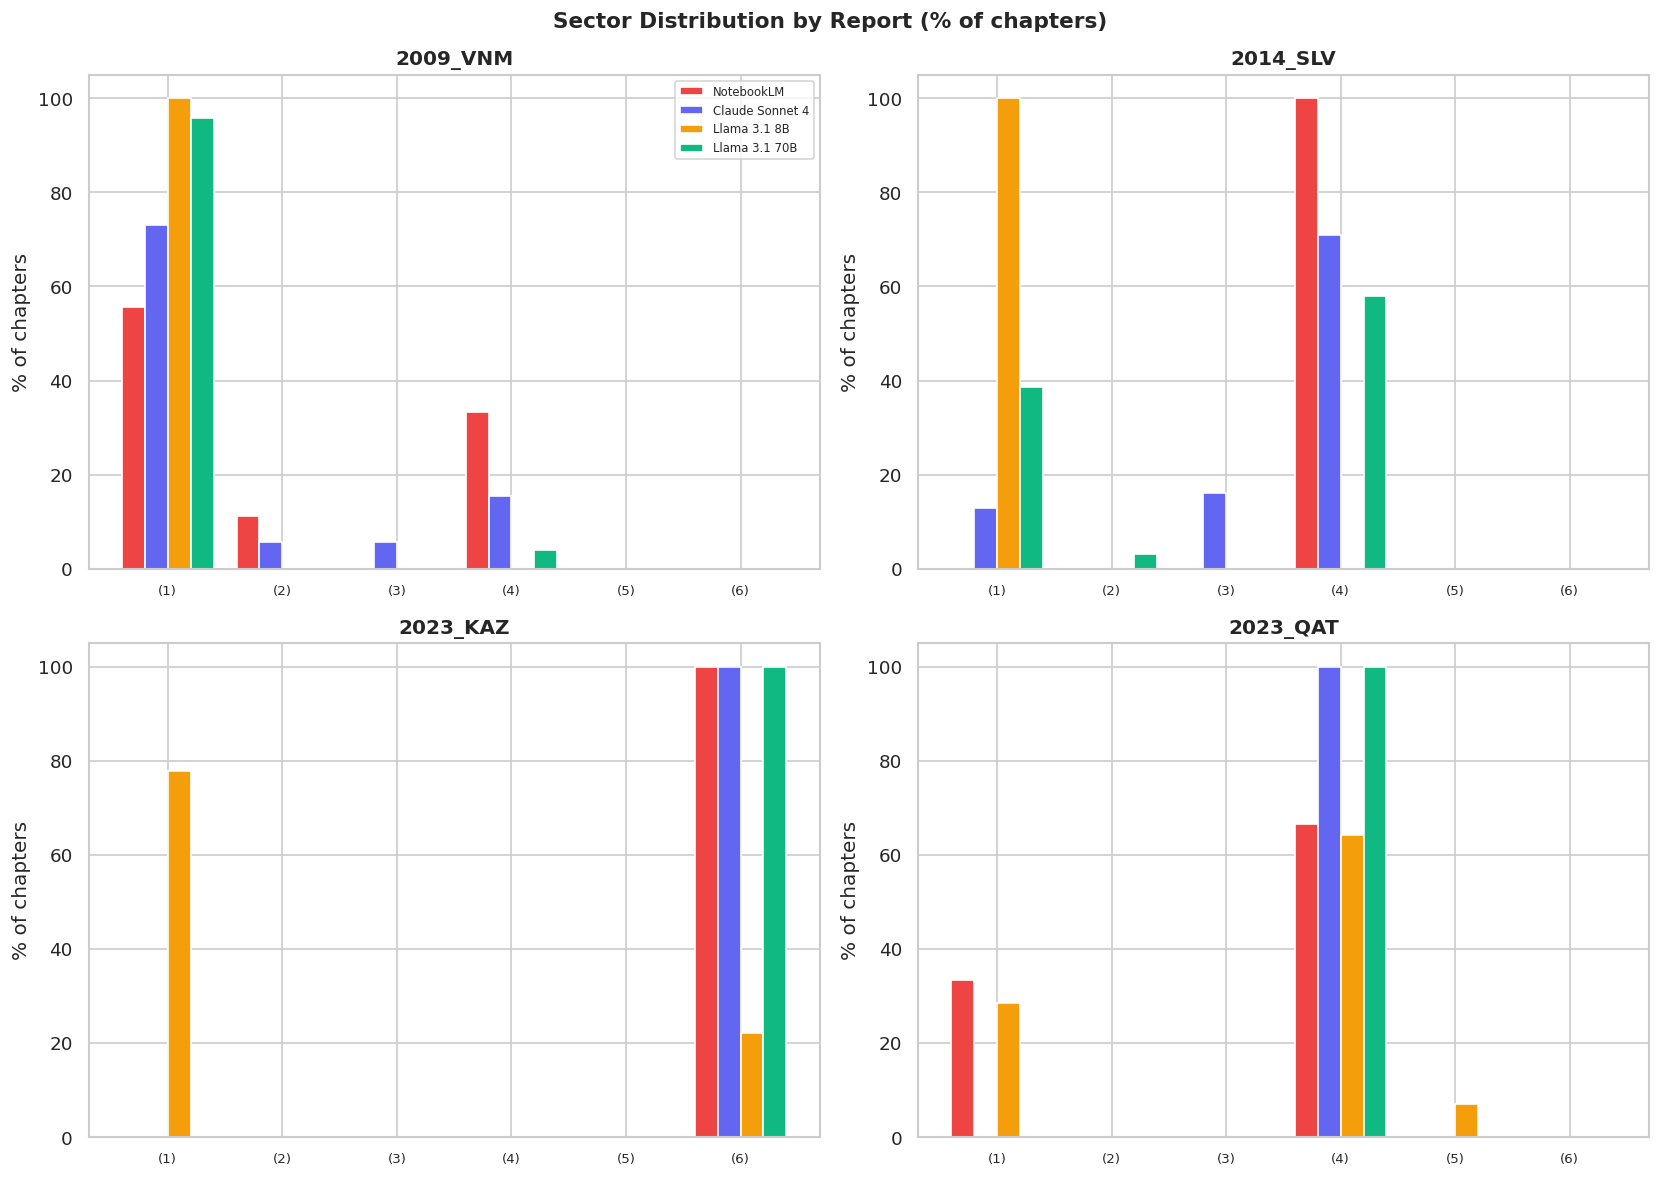

In [7]:
# --- Sector distribution by report ---
# For each source and report, count primary sector assignments

def get_report_sector_counts(source_label):
    """Return {report_short: Counter(sector -> count)} for a given source."""
    counts = defaultdict(Counter)
    if source_label == 'NotebookLM':
        for d in nlm_data:
            counts[d['report_short']][d['primary_sector']] += 1
    else:
        for d in pipeline[source_label]:
            if 'error' not in d:
                rs = d['report_id'][:8]
                sectors = d['taxonomy_classification']['sectors']
                if sectors:
                    counts[rs][normalize_sector(sectors[0]['sector'])] += 1
    return counts

all_report_shorts = sorted(REPORT_MAP.keys())

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for ax, rs in zip(axes.flat, all_report_shorts):
    sector_counts = {}
    for label in ALL_LABELS:
        rc = get_report_sector_counts(label)
        total = sum(rc[rs].values()) or 1
        sector_counts[label] = {s: rc[rs].get(s, 0) / total * 100 for s in SECTOR_NAMES}

    x = np.arange(len(SECTOR_NAMES))
    width = 0.2
    for i, label in enumerate(ALL_LABELS):
        vals = [sector_counts[label].get(s, 0) for s in SECTOR_NAMES]
        ax.bar(x + i * width, vals, width, label=label, color=COLORS[label])

    ax.set_title(rs, fontweight='bold')
    ax.set_ylabel('% of chapters')
    ax.set_xticks(x + 1.5 * width)
    short_labels = [f'({s.split(")")[0].split("(")[1]})' for s in SECTOR_NAMES]
    ax.set_xticklabels(short_labels, fontsize=8)
    ax.set_ylim(0, 105)

axes[0, 0].legend(fontsize=7, loc='upper right')
fig.suptitle('Sector Distribution by Report (% of chapters)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

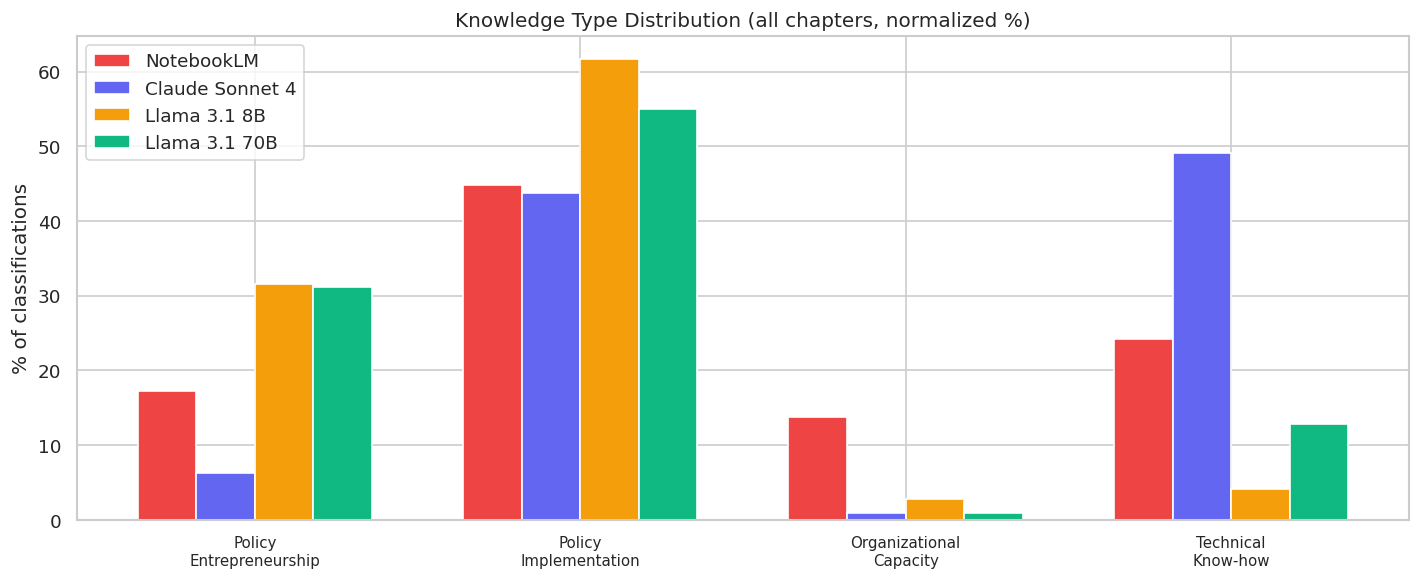

Raw knowledge type counts:
  NotebookLM: Policy Entrepre: 5, Policy Implemen: 13, Organizational/: 4, Technical Know-: 7 (total=29)
  Claude Sonnet 4: Policy Entrepre: 7, Policy Implemen: 49, Organizational/: 1, Technical Know-: 55 (total=112)
  Llama 3.1 8B: Policy Entrepre: 23, Policy Implemen: 45, Organizational/: 2, Technical Know-: 3 (total=73)
  Llama 3.1 70B: Policy Entrepre: 34, Policy Implemen: 60, Organizational/: 1, Technical Know-: 14 (total=109)


In [8]:
# --- Knowledge type distribution (overall) ---
def get_overall_kt_counts(source_label):
    counts = Counter()
    if source_label == 'NotebookLM':
        for d in nlm_data:
            # NLM can have multiple KTs per chapter — count each once
            for kt in d['knowledge_types']:
                counts[kt] += 1
    else:
        for d in pipeline[source_label]:
            if 'error' not in d:
                counts[d['taxonomy_classification']['knowledge_type']] += 1
    return counts

fig, ax = plt.subplots(figsize=(12, 5))
x = np.arange(len(KNOWLEDGE_TYPES))
width = 0.18

for i, label in enumerate(ALL_LABELS):
    kt_counts = get_overall_kt_counts(label)
    total = sum(kt_counts.values()) or 1
    pcts = [kt_counts.get(kt, 0) / total * 100 for kt in KNOWLEDGE_TYPES]
    ax.bar(x + i * width, pcts, width, label=label, color=COLORS[label])

ax.set_ylabel('% of classifications')
ax.set_title('Knowledge Type Distribution (all chapters, normalized %)')
ax.set_xticks(x + 1.5 * width)
kt_short = ['Policy\nEntrepreneurship', 'Policy\nImplementation',
             'Organizational\nCapacity', 'Technical\nKnow-how']
ax.set_xticklabels(kt_short, fontsize=9)
ax.legend()
plt.tight_layout()
plt.show()

# Print raw counts
print('Raw knowledge type counts:')
for label in ALL_LABELS:
    kt_counts = get_overall_kt_counts(label)
    total = sum(kt_counts.values())
    parts = ', '.join(f'{kt.split("(")[0].strip()[:15]}: {kt_counts.get(kt, 0)}'
                      for kt in KNOWLEDGE_TYPES)
    print(f'  {label}: {parts} (total={total})')

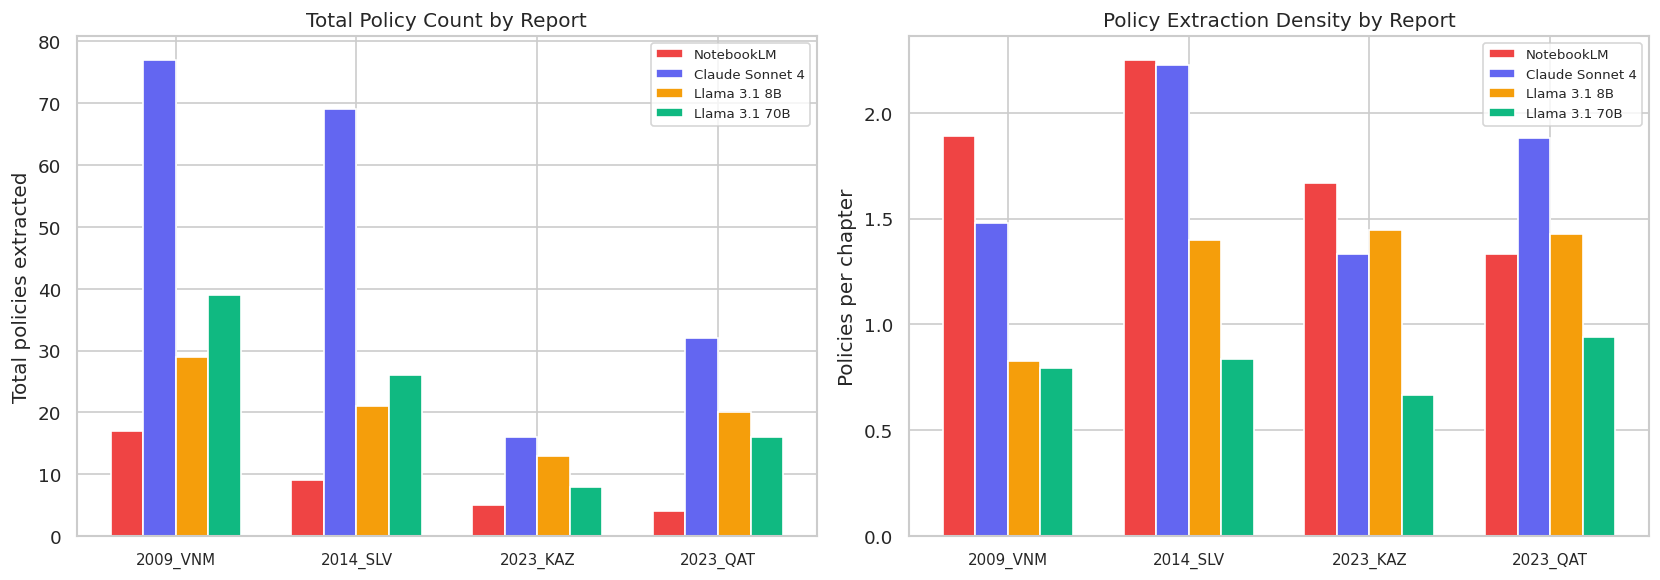

In [9]:
# --- Policy extraction density by report ---
def get_report_policy_counts(source_label):
    counts = Counter()
    n_chapters = Counter()
    if source_label == 'NotebookLM':
        for d in nlm_data:
            counts[d['report_short']] += d['n_policies']
            n_chapters[d['report_short']] += 1
    else:
        for d in pipeline[source_label]:
            if 'error' not in d:
                rs = d['report_id'][:8]
                counts[rs] += count_pipeline_policies(d)
                n_chapters[rs] += 1
    return counts, n_chapters

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Total policies per report
x = np.arange(len(all_report_shorts))
width = 0.18
for i, label in enumerate(ALL_LABELS):
    pol_counts, _ = get_report_policy_counts(label)
    vals = [pol_counts.get(rs, 0) for rs in all_report_shorts]
    ax1.bar(x + i * width, vals, width, label=label, color=COLORS[label])
ax1.set_ylabel('Total policies extracted')
ax1.set_title('Total Policy Count by Report')
ax1.set_xticks(x + 1.5 * width)
ax1.set_xticklabels(all_report_shorts, fontsize=9)
ax1.legend(fontsize=8)

# Policies per chapter (density)
for i, label in enumerate(ALL_LABELS):
    pol_counts, n_ch = get_report_policy_counts(label)
    vals = [pol_counts.get(rs, 0) / max(n_ch.get(rs, 1), 1) for rs in all_report_shorts]
    ax2.bar(x + i * width, vals, width, label=label, color=COLORS[label])
ax2.set_ylabel('Policies per chapter')
ax2.set_title('Policy Extraction Density by Report')
ax2.set_xticks(x + 1.5 * width)
ax2.set_xticklabels(all_report_shorts, fontsize=9)
ax2.legend(fontsize=8)

plt.tight_layout()
plt.show()

## Section 5: Summary

In [10]:
# Agreement summary across all models vs NLM at chapter level
print('=' * 70)
print('NLM vs PIPELINE COMPARISON SUMMARY')
print('=' * 70)
print()

# 1. Chapter-level agreement for each model
print('1. CHAPTER-LEVEL AGREEMENT (NLM vs aggregated pipeline)')
print('-' * 50)
for model in MODEL_LABELS:
    s_agree = 0
    kt_agree = 0
    n_compared = 0
    for rs in nlm_by_report:
        for e in nlm_by_report[rs]:
            agg = aggregate_subchapters(e['matched'][model], model)
            if agg['n'] == 0:
                continue
            n_compared += 1
            if e['primary_sector'] == agg['sector']:
                s_agree += 1
            if e['primary_kt'] == agg['kt']:
                kt_agree += 1
    print(f'  {model}:')
    print(f'    Sector:  {s_agree}/{n_compared} ({s_agree/n_compared*100:.1f}%)')
    print(f'    KT:      {kt_agree}/{n_compared} ({kt_agree/n_compared*100:.1f}%)')
print()

# 2. Overall distribution comparison
print('2. KNOWLEDGE TYPE DISTRIBUTION COMPARISON')
print('-' * 50)
for label in ALL_LABELS:
    kt_counts = get_overall_kt_counts(label)
    total = sum(kt_counts.values())
    top = kt_counts.most_common(1)[0]
    print(f'  {label}: top KT = "{top[0].split("(")[0].strip()}"'
          f' ({top[1]}/{total}, {top[1]/total*100:.0f}%)')
print()

# 3. Policy extraction
print('3. POLICY EXTRACTION TOTALS')
print('-' * 50)
for label in ALL_LABELS:
    pol_counts, n_ch = get_report_policy_counts(label)
    total_pol = sum(pol_counts.values())
    total_ch = sum(n_ch.values())
    density = total_pol / total_ch if total_ch else 0
    print(f'  {label}: {total_pol} policies from {total_ch} chapters'
          f' ({density:.1f} per chapter)')
print()

# 4. Key observations
print('4. KEY OBSERVATIONS')
print('-' * 50)
print('  - NLM analyzed 19 top-level chapters; pipeline analyzed 112 sub-chapters')
print('  - NLM assigns multiple knowledge types per chapter;')
print('    pipeline assigns exactly one')
print('  - NLM policy density is higher (fewer chapters, focused extraction)')
print('  - Sector agreement depends on how sub-chapter aggregation resolves')
print('    majority votes — heterogeneous sub-chapters may produce different')
print('    primary sectors than NLM\'s holistic classification')

NLM vs PIPELINE COMPARISON SUMMARY

1. CHAPTER-LEVEL AGREEMENT (NLM vs aggregated pipeline)
--------------------------------------------------
  Claude Sonnet 4:
    Sector:  15/19 (78.9%)
    KT:      9/19 (47.4%)
  Llama 3.1 8B:
    Sector:  5/18 (27.8%)
    KT:      7/18 (38.9%)
  Llama 3.1 70B:
    Sector:  13/19 (68.4%)
    KT:      7/19 (36.8%)

2. KNOWLEDGE TYPE DISTRIBUTION COMPARISON
--------------------------------------------------
  NotebookLM: top KT = "Policy Implementation & Coordinating Mechanism" (13/29, 45%)
  Claude Sonnet 4: top KT = "Technical Know-how" (55/112, 49%)
  Llama 3.1 8B: top KT = "Policy Implementation & Coordinating Mechanism" (45/73, 62%)
  Llama 3.1 70B: top KT = "Policy Implementation & Coordinating Mechanism" (60/109, 55%)

3. POLICY EXTRACTION TOTALS
--------------------------------------------------
  NotebookLM: 35 policies from 19 chapters (1.8 per chapter)
  Claude Sonnet 4: 194 policies from 112 chapters (1.7 per chapter)
  Llama 3.1 8B: 83 p